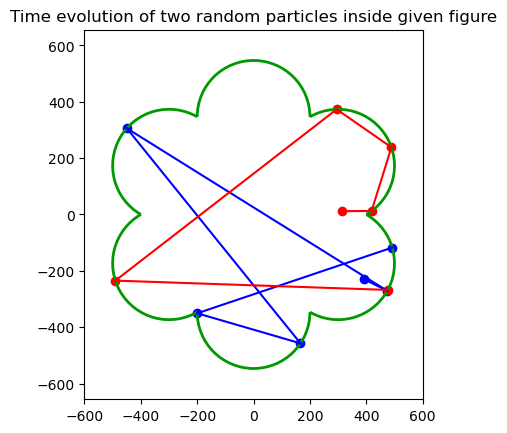

PyObject Text(0.5, 1.0, 'Time evolution of two random particles inside given figure')

In [62]:
using DynamicalBilliards, PyPlot

bd=Obstacle{Float64}[]

r = 200
a = r*cos(0)
b = r*cos(pi/6)
c = r*cos(pi/3)
d = r*cos(pi/2)

s2=Semicircle([0,2*b],r,[0,-1])
s4=Semicircle([0,-2*b],r,[0,1])
s6=Semicircle([-(a+c),-(d+b)],r,[(a+c),(d+b)])
s8=Semicircle([-(a+c),(d+b)],r,[(a+c),-(d+b)])
s9=Semicircle([(a+c),-(d+b)],r,[-(a+c),(d+b)])
s0=Semicircle([(a+c),(d+b)],r,[-(a+c),-(d+b)])

push!(bd,s2)
push!(bd,s4)
push!(bd,s6)
push!(bd,s8)
push!(bd,s9)
push!(bd,s0)

bill=Billiard(bd)

p1=randominside(bill)
p2=randominside(bill)

import DynamicalBilliards: increment_counter

import DynamicalBilliards: isperiodic

import DynamicalBilliards: evolve!

function evolve!(p::AbstractParticle{T}, bd::Billiard{T}, t, raysplitters = nothing;
    warning = false) where {T<:AbstractFloat}

    if t ≤ 0
        throw(ArgumentError("`evolve!()` cannot evolve backwards in time."))
    end
    if ispinned(p, bd)
        push!(rpos, p.pos)
        push!(rvel, p.vel)
        push!(rt, Inf)
        return (rt, rpos, rvel, p.ω)
    end

    ismagnetic = p isa MagneticParticle
    isray = !isa(raysplitters, Nothing)
    isray && acceptable_raysplitter(raysplitters, bd)
    raysidx = raysplit_indices(bd, raysplitters)
    ismagnetic && isray && (omegas = [p.ω])

    rt = T[0.0]; rpos = [p.pos]; rvel = [p.vel]
    count = zero(t)
    flight = zero(T)
    if typeof(t) == Int
        for zzz in (rt, rpos, rvel)
            sizehint!(zzz, t)
        end
    end

    while count < t

        i, tmin, pos, vel = bounce!(p, bd, raysidx, raysplitters)
        flight += tmin

        if isperiodic(i, bd)
            continue
        else
            push!(rpos, pos + p.current_cell)
            push!(rvel, vel)
            push!(rt, flight)
            ismagnetic && isray && push!(omegas, p.ω)
            # set counter
            count += increment_counter(t, flight)
            flight = zero(T)
        end
        
        if pos==(-c,b)||pos==(c,b)||pos==(c,-b)||pos==(-c,-b)||pos==(-a,d)||pos==(a,d)
            break;
        end
    end  #time, or collision number, loop

    # Return stuff
    if ismagnetic && isray
        return (rt, rpos, rvel, omegas)
    elseif ismagnetic
        return (rt, rpos, rvel, p.ω)
    else
        return (rt, rpos, rvel)
    end
end

history1=evolve!(p1,bill,5)
history2=evolve!(p2,bill,5)

PyPlot.plot(bill)
for i=1:lastindex(history1[2])
    l1=[history1[2][i][1],history1[2][i][2]]
    l2=[history2[2][i][1],history2[2][i][2]]
    PyPlot.scatter(l1[1],l1[2],color=:blue)
    PyPlot.scatter(l2[1],l2[2],color=:red)
    if i==1
        continue
    end
    l01=history1[2][i-1][1],history1[2][i-1][2]
    l02=history2[2][i-1][1],history2[2][i-1][2]
    PyPlot.plot((l1[1],l01[1]),(l1[2],l01[2]), color=:blue)
    PyPlot.plot((l2[1],l02[1]),(l2[2],l02[2]), color=:red)
end
PyPlot.title("Time evolution of two random particles inside given figure")